In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [3]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.iclr.helper import load_multiple_version_of_pcs
from tf_lab.neural_net import MODEL_SAVER_ID

from tf_lab.evaluate.generative_pc_nets import entropy_of_occupancy_grid, jensen_shannon_divergence
from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, point_cloud_generator,\
leaky_relu

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
save_model = False
do_training = True
plot_train_curve = False
save_synthetic_samples = np.hstack([np.array([1, 5, 10]), np.arange(50, 2001, 50)])
class_name = raw_input('Give me the class type.\n').lower()
syn_id = snc_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/r_gan/'

Give me the class type.
chair


In [6]:
n_pc_points = 2048
max_epochs = 2000
arch_tag = 'replica_of_nips'

leak = 0.2
adaptive_training = None
beta = 0.9

discriminator = mlp_discriminator
generator = point_cloud_generator

batch_size = 50
noise_params = {'mu':0, 'sigma': 0.5}
noise_dim = 512
init_lr = 0.0001

disc_kwargs = {'non_linearity': leaky_relu(leak), 'b_norm': False}
gen_kwargs = {'b_norm': False}

experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_points) +  '_pts'

In [7]:
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)

Loading test data.
/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/test.txt
679 pclouds were loaded. They belong in 1 shape-classes.
Loading train data.
/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/train.txt
5761 pclouds were loaded. They belong in 1 shape-classes.
Loading val data.
/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/val.txt
338 pclouds were loaded. They belong in 1 shape-classes.


In [8]:
training_data = in_data['train']
n_syn_samples = training_data.num_examples  # Same number as original GT data.

In [9]:
reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_points, 3], noise_dim,
             discriminator, generator, beta=beta, gen_kwargs=gen_kwargs, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

1 (1.3621516341748445, 0.74846539704695991) 26.4965620041


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


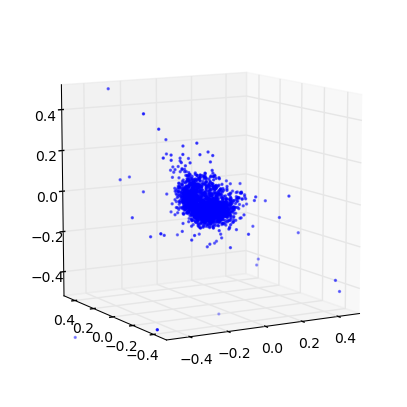

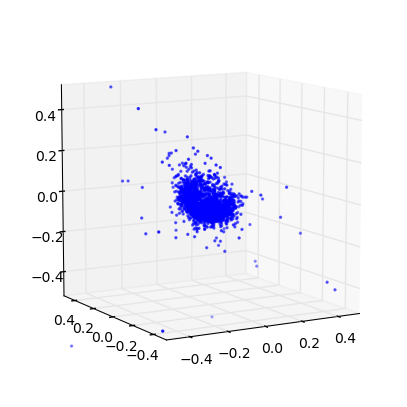

2 (1.3668069144953852, 0.74774109125137334) 26.2245879173
3 (1.3281401395797729, 0.78553409472755764) 26.3277058601
4 (1.3351941326390142, 0.82880398708841074) 26.4145941734
5 (1.3712774059046871, 0.77436649643856548) 26.4566800594


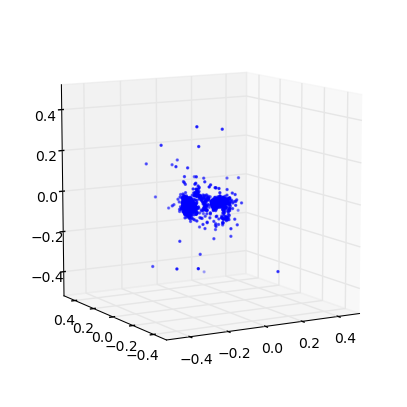

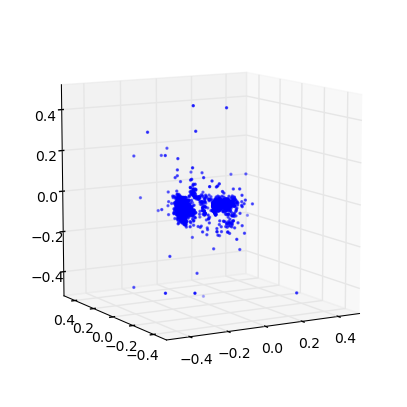

6 (1.4423405035682346, 0.86586134537406589) 26.4628908634
7 (1.2993075225664221, 0.84673931650493461) 26.4717311859
8 (1.3124309861141703, 0.83351618181104248) 26.4863500595
9 (1.3507820875748344, 0.6773198853368344) 26.4964549541
10 (1.2897957978041277, 0.809138836549676) 26.4424028397


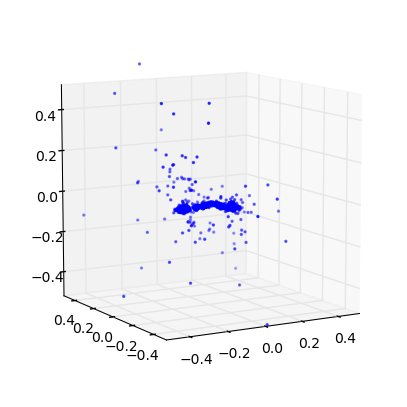

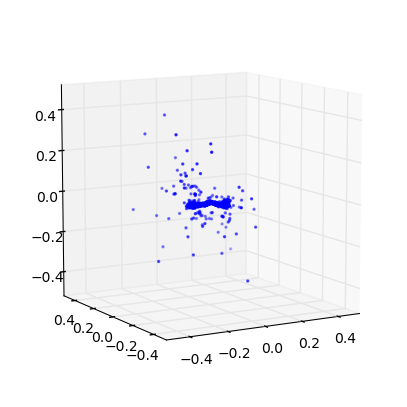

11 (1.2529009590978208, 0.92043233695237536) 26.4610798359
12 (1.4273594265398772, 0.77667354785877729) 26.4308209419
13 (1.3514633769574373, 0.71680417268172558) 26.4837489128
14 (1.2227205095083817, 0.90249362199202832) 26.4386291504
15 (1.1256310836128567, 1.0457138719766037) 26.4269990921
16 (1.3821988494499871, 1.3299095013867255) 26.4544460773
17 (1.1773489221282627, 0.82624292373657227) 26.3914330006
18 (1.3160316550213358, 0.92710748263027354) 26.4277758598
19 (1.1917381234790967, 0.96391586790914119) 26.4186630249
20 (1.237059383806975, 1.0329393003297889) 26.3780789375
21 (1.0661633019861967, 0.85930144009382825) 26.4042110443
22 (1.0759591755659683, 1.2994560889575792) 26.4465799332
23 (1.2744086462518442, 1.2335257198499596) 26.4283349514
24 (0.99193464569423506, 1.0892020220341889) 26.41624403
25 (0.70644746500512823, 1.5443740606307983) 26.4279770851
26 (1.0653794713642286, 1.3947493687919947) 26.4321429729
27 (0.83742710351943972, 1.4014833875324415) 26.4145741463
28 (0.

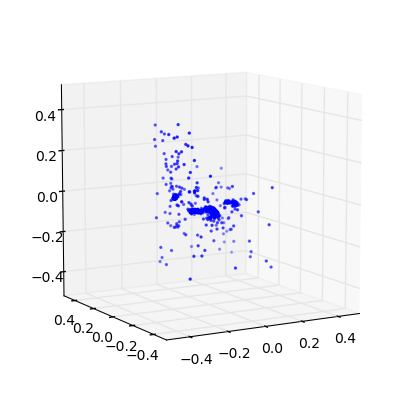

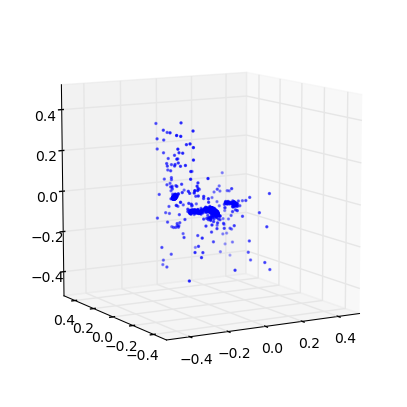

51 (1.0134414947551229, 1.2474821645280589) 26.4485719204
52 (1.2437868875005971, 1.2455324338830036) 26.424696207
53 (1.1799776274224987, 1.1593389568121537) 26.4687619209
54 (1.0390976662221163, 1.4417323096938754) 26.433123827
55 (1.6408709557160088, 1.2226127235785775) 26.4802658558
56 (0.96329532576643906, 1.4265389406162761) 26.4181170464
57 (1.1219266383544257, 1.1966578970784727) 26.4341869354
58 (1.4367162554160409, 0.93524507906125942) 26.4322330952
59 (1.2353767130685889, 0.95809589054273525) 26.4565389156
60 (1.1647304908089016, 1.0998777405075404) 26.4471259117
61 (1.5847670166388801, 1.0021075321280437) 26.4226138592
62 (1.433429331364839, 0.91521765097327856) 26.4655609131
63 (1.3342685450678287, 0.85762840146603792) 26.4745309353
64 (1.466633147260417, 0.92303160169850229) 26.4176068306
65 (1.3481859979422197, 0.78145805338154672) 26.415222168
66 (1.2874837046084198, 0.92748608485512107) 37.0083949566
67 (1.3015633396480395, 0.80954571288564936) 43.0382189751
68 (1.3173

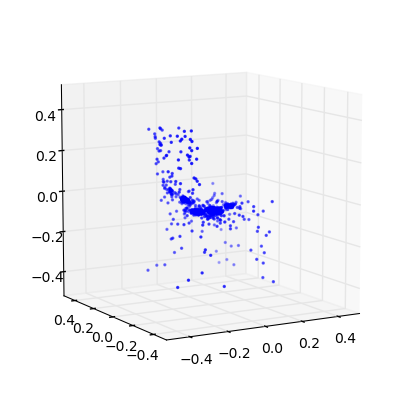

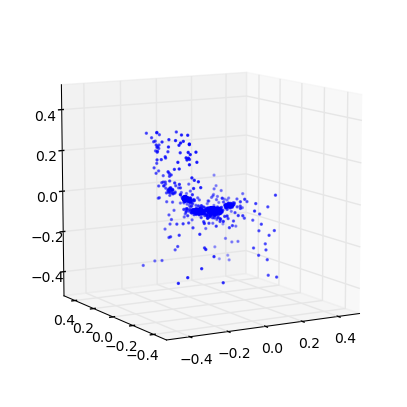

101 (1.1279240069182024, 1.0802368568337481) 43.4272770882
102 (1.0881581793660704, 1.1074838726416878) 43.619259119
103 (0.97002769864123806, 1.265492161978846) 43.3804850578
104 (1.1356650865596274, 1.1600075815034949) 42.9605329037
105 (1.0099592841189839, 1.1209162411482438) 43.1146259308
106 (0.9767782356428063, 1.1375887725664222) 32.4710540771
107 (1.0600683056789897, 1.0989890746448352) 26.4019351006
108 (0.93605032796445098, 1.1647884047549704) 26.434926033
109 (0.99360123769096709, 1.1250187692434892) 26.4285759926
110 (1.0162535786628724, 1.2470451059548751) 26.4405760765
111 (1.0465693826260773, 1.1702164297518522) 42.3929600716
112 (1.0652139668879301, 1.1223745195761972) 30.8032381535
113 (1.0044702084168144, 1.2086155264273934) 26.4426538944
114 (1.0653383177259694, 1.1848543960115183) 26.5534939766
115 (1.003512256041817, 1.1560575272725977) 26.5113620758
116 (1.0706786679184954, 1.2426692459894264) 26.5216388702
117 (1.0900960937790249, 1.116813216779543) 39.4244379997

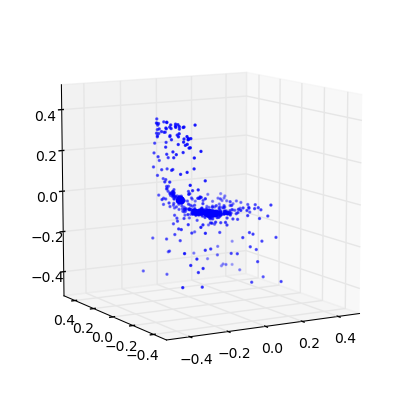

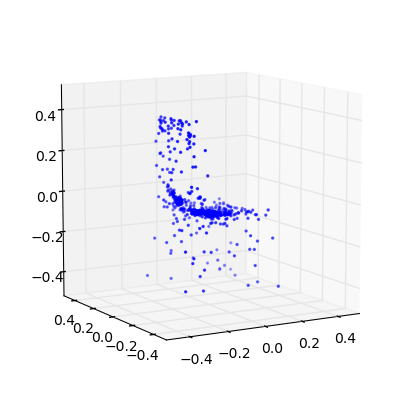

151 (0.77686044444208557, 1.5460414580676867) 26.6961979866
152 (0.83679880888565727, 1.4202180084974869) 27.1508848667
153 (0.96868799562039587, 1.2748472146365954) 26.6037828922
154 (0.79399593705716343, 1.4160981567009636) 26.7121379375
155 (0.91204987038736762, 1.3052592236062754) 26.9844470024
156 (0.76723229833271189, 1.4153762594513271) 26.9980700016
157 (0.86915893295536872, 1.3681306232576784) 26.5762228966
158 (0.87120211176250295, 1.3840826801631763) 26.7486138344
159 (1.0014692814453789, 1.233991519264553) 26.7346720695
160 (0.91879149053407749, 1.311061814556951) 26.9556980133
161 (0.89058352397835772, 1.3758450653242029) 26.8553109169
162 (0.86432497760523919, 1.4143494663031204) 26.920386076
163 (0.92325497191885242, 1.3900075736253157) 26.7896809578
164 (0.82554322792136148, 1.4658725049184715) 26.7835388184
165 (0.94008115944655046, 1.3703716112219768) 27.1036410332
166 (0.99404106502947598, 1.3747401123461516) 26.8059449196
167 (0.8344538958176323, 1.4932904393776603)

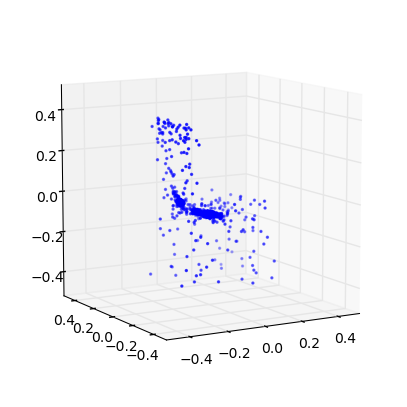

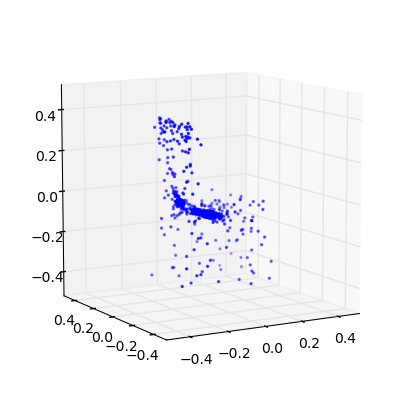

201 (0.71012612814488618, 1.6122146969256195) 26.7187662125
202 (0.68153546737587967, 1.6718388137610063) 26.6937000751
203 (0.64152662702228713, 1.8259144829667133) 26.8357989788
204 (0.79282797108525815, 1.6369658589363099) 26.9085769653
205 (0.73270708685335906, 1.624171915779943) 26.8543150425
206 (0.67999912578126653, 1.7617889290270599) 26.6372489929
207 (0.68202544062033943, 1.8966587678245876) 27.1480791569
208 (0.63977841190669849, 1.8217931265416352) 26.9242608547
209 (0.66536784197973164, 1.7907716486764991) 26.6713578701
210 (0.67438793104627859, 1.7013485696004784) 26.8808479309
211 (0.60642519023107444, 1.7716323904369189) 26.956097126
212 (0.5468050111895022, 1.8887200428091961) 26.6939558983
213 (0.59526756302170136, 1.9336042248684426) 26.8207550049
214 (0.56450660772945571, 2.008774375397226) 26.8504519463
215 (0.53723489564398064, 2.0132839907770572) 27.039345026
216 (0.66932846670565393, 1.9593350203140922) 26.9152331352
217 (0.69887588827506353, 1.7376658792081086)

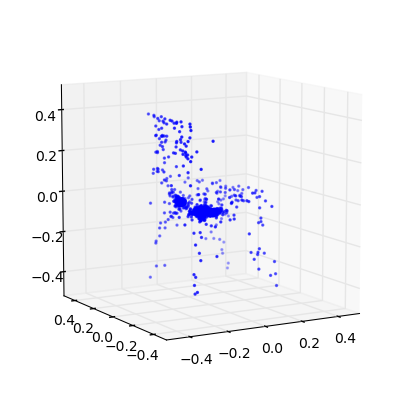

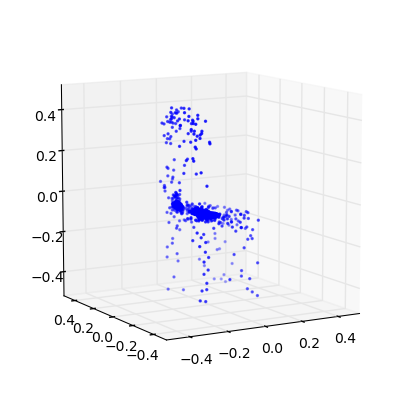

251 (0.74999597720477895, 1.7321757565373961) 26.5989289284
252 (0.87727654654046761, 1.7464105155157006) 26.730440855
253 (0.80820745385211445, 1.7183071981305662) 26.648763895
254 (0.72884989380836485, 1.6992797214051951) 26.8585650921
255 (0.69037702601888906, 1.9350064311338508) 26.6074590683
256 (0.76271617879038267, 1.6965178676273511) 26.7115080357
257 (0.73433402206586751, 1.6118743409281191) 26.85384202
258 (0.71049721033676816, 1.6133135609004809) 26.6250579357
259 (0.79557622230571245, 1.6026272136232127) 26.6829681396
260 (0.78466340044270388, 1.5453261447989421) 26.852711916
261 (0.76956545192262404, 1.5644649925439253) 26.7031481266
262 (0.71962230931157656, 1.7329446248386218) 26.8302309513
263 (0.79709015229473945, 1.6746417719384898) 26.7857859135
264 (0.70337546053140054, 1.7187323337015898) 26.8389291763
265 (0.73010106708692468, 1.7262637643710426) 26.8493680954
266 (0.80515452960263123, 1.6131531751674155) 26.7548930645
267 (0.7499821139418561, 1.6234063044838283) 

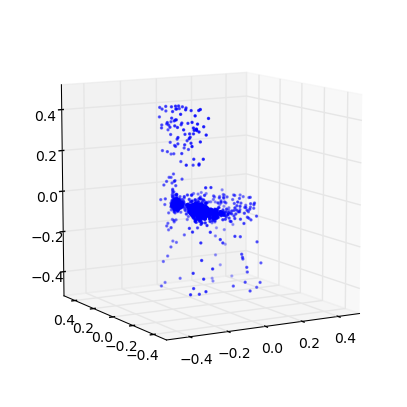

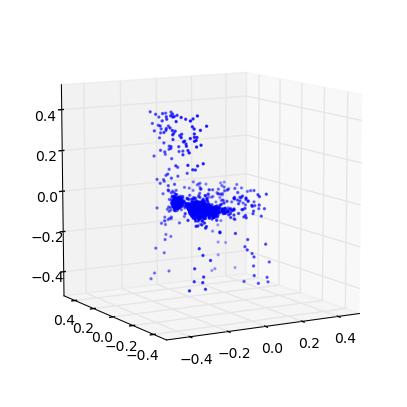

301 (0.64808470762294268, 1.8593029317648515) 26.6122429371
302 (0.67647757141486453, 1.9420806988425876) 26.5334219933
303 (0.62075248697529672, 1.9598030841868856) 27.1373708248
304 (0.62322684111802473, 1.9889555392058) 26.7714679241
305 (0.65973529090052063, 1.8143378522085107) 26.9804899693
306 (0.61231791791708579, 1.8806304506633593) 26.8428220749
307 (0.61749925509743064, 1.9085246158682783) 26.6225321293
308 (0.66576222777366634, 1.8212094382099484) 26.7515311241
309 (0.64592320037924722, 1.8221568496330924) 26.8849339485
310 (0.66141131494356242, 1.750903458698936) 26.723886013
311 (0.63537909129391545, 1.868273013052733) 26.866065979
312 (0.66307669748430664, 1.8399233771407086) 26.5854671001
313 (0.58187322461086766, 1.9479405040326325) 26.6705040932
314 (0.57099249751671499, 1.9685408312341441) 27.0186779499
315 (0.51550579226535298, 2.1020998633426169) 26.6645450592
316 (0.54929700156916739, 2.0785938853802888) 26.7839009762
317 (0.48978038469086521, 2.2885238186172816) 2

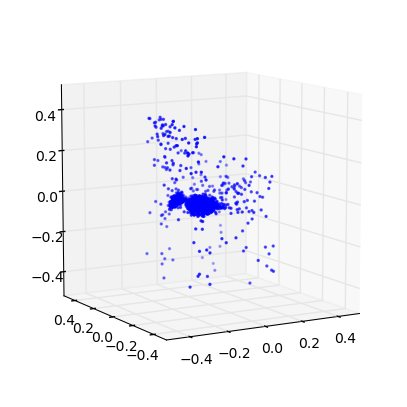

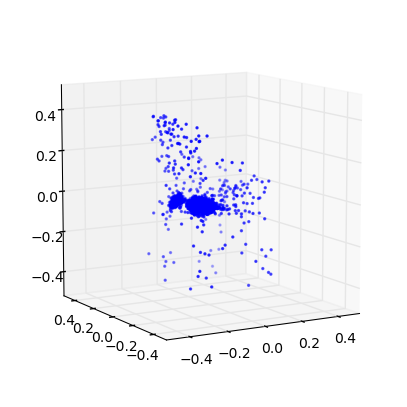

351 (0.59288337204767305, 2.0283844958180968) 26.7858221531
352 (0.60496528977933139, 2.0236628589422807) 26.6456811428
353 (0.53587147723073547, 2.1322743535041808) 26.8296301365
354 (0.54872347479281214, 2.0425601865934291) 27.1221249104
355 (0.46833958081577137, 2.0510222009990526) 26.9911270142
356 (0.50790412775848226, 2.1917885977288951) 26.9034180641
357 (0.55969935836999307, 2.2803899842759838) 26.5655720234
358 (0.543132228695828, 2.1610242149104244) 26.8561549187
359 (0.57918927876845649, 2.3374225248461182) 26.7697851658
360 (0.5141683062781458, 2.1239928442498912) 26.611686945
361 (0.52453706083090412, 2.1104092857112056) 26.7752599716
362 (0.54429599305857779, 2.1279918224915213) 26.9681630135
363 (0.46191157841164132, 2.3985304987948872) 26.8456699848
364 (0.46144591621730641, 2.3143352850623753) 26.7827310562
365 (0.5205579692902772, 2.3461916083874912) 26.7618100643
366 (0.58247160781984741, 2.2525918577028357) 26.6306622028
367 (0.49913854495338772, 2.3293838889702507)

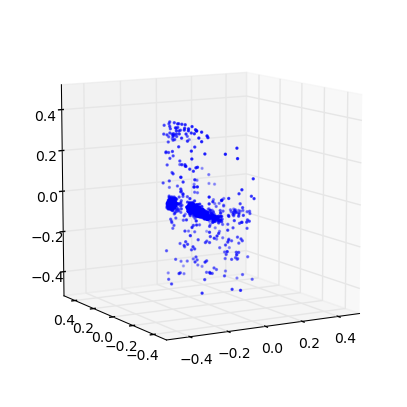

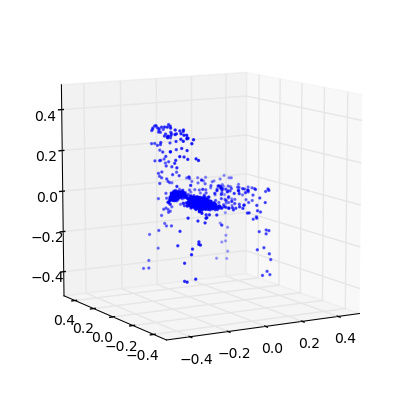

401 (0.55474660318830737, 2.1956530700559203) 26.7294781208
402 (0.62655658125877378, 2.1169532801793971) 26.8094668388
403 (0.4821671742460002, 2.2754093647003173) 27.090526104
404 (0.50216088346813037, 2.2161014525786689) 26.9654560089
405 (0.52263246437777644, 2.149812364578247) 26.62241292
406 (0.4907170119492904, 2.3233198518338409) 26.8507909775
407 (0.47247563483922378, 2.4093617408171943) 26.721670866
408 (0.52605044893596486, 2.3694828287414884) 27.0772781372
409 (0.50616391340027689, 2.3673652172088624) 26.7501969337
410 (0.55803375295970747, 2.0962045171986454) 26.7606871128
411 (0.54077653470246689, 2.2858369495557702) 26.920732975
412 (0.55979837878890659, 2.4977613928525346) 27.0107779503
413 (0.54722691307897153, 2.3671507249707759) 26.8085339069
414 (0.54926704660705894, 2.2151026798331217) 26.774474144
415 (0.5166656895824101, 2.2610804930977197) 26.7918798923
416 (0.61857542615869776, 2.5747535806635153) 26.6512789726
417 (0.54105219763258228, 2.0849405692971272) 26.6

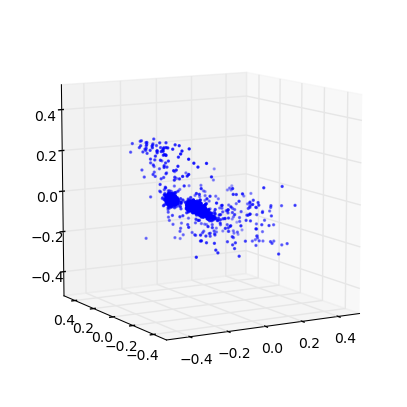

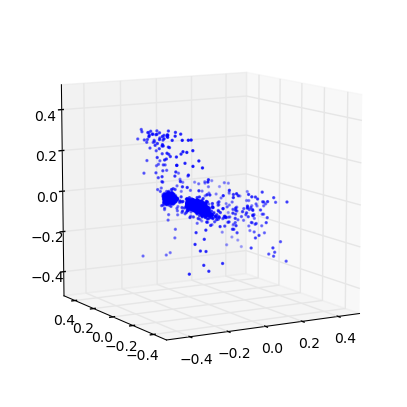

451 (0.5455538973860119, 2.6506548474664275) 26.913985014
452 (0.5700184954249341, 2.6240824168143067) 26.6518118382
453 (0.45166033843289249, 2.6787345217621845) 27.261111021
454 (0.51525966201139528, 2.5738259232562521) 26.9746239185
455 (0.52318098622819653, 2.4655277443968733) 28.2487149239
456 (0.47523663095805957, 2.3997451398683629) 28.3468379974
457 (0.43655628108459971, 2.4553540291993516) 28.0196249485
458 (0.53322531386562011, 2.5077387488406639) 28.2587599754
459 (0.45196798080983369, 2.4133669521497643) 28.1942949295
460 (0.42827786958735919, 2.3796454471090565) 28.2724199295
461 (0.40436085851296133, 2.3799025535583498) 28.2931938171
462 (0.50499833783377768, 2.6344720068185228) 28.2515180111
463 (0.57895480886749595, 2.4037543403065724) 28.2802450657
464 (0.43931092244127523, 2.3856006052183067) 28.0714261532
465 (0.41194084960481397, 2.5206634676974753) 28.2134799957
466 (0.42349307226098104, 2.3103655680366186) 28.2684001923
467 (0.42800718766191731, 2.4561214099759643

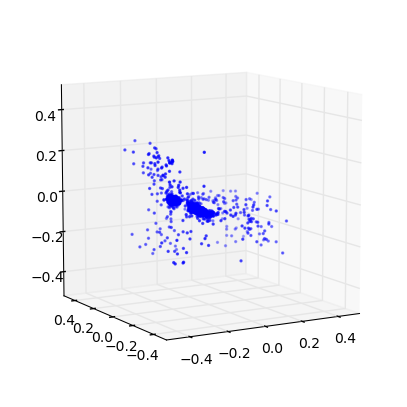

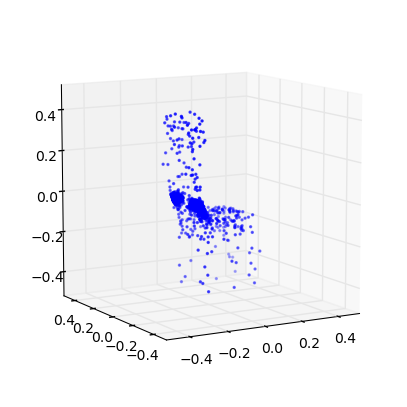

501 (0.47011347516723301, 2.7308688288149625) 28.3163239956
502 (0.57063056897857911, 2.9972306267074917) 28.5287139416
503 (0.59293467234010278, 2.6537441419518513) 28.3967690468
504 (0.44107334147328914, 2.5933985855268396) 28.5189838409
505 (0.42119368133337604, 2.5431631865708724) 28.4947161674
506 (0.54495029656783389, 2.9113485984180283) 28.5005679131
507 (0.5256800546594288, 2.6596306303273076) 28.5666730404
508 (0.46969721019268035, 2.6561018871224444) 28.3488631248
509 (0.46411042602165886, 2.5714811636053998) 28.3636980057
510 (0.45190681594869364, 2.6365675718887993) 28.3579349518
511 (0.47995451546233631, 2.4916433375814688) 28.742773056
512 (0.52766956142757249, 2.5456883103951164) 28.5931069851
513 (0.37929381378318955, 2.6125505136406941) 28.3741149902
514 (0.42399254117323004, 2.7012305176776388) 28.5755929947
515 (0.49754850760750147, 2.964203549467999) 28.562484026
516 (0.44271964119828267, 2.5033378730649534) 28.3872661591
517 (0.53910968951556992, 2.3984129278556159

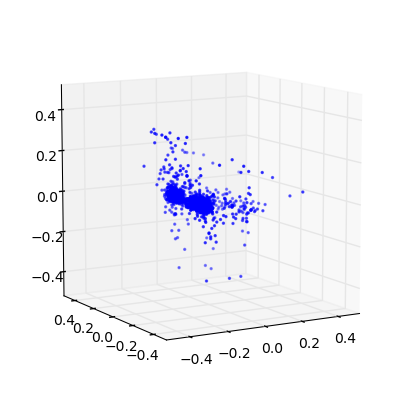

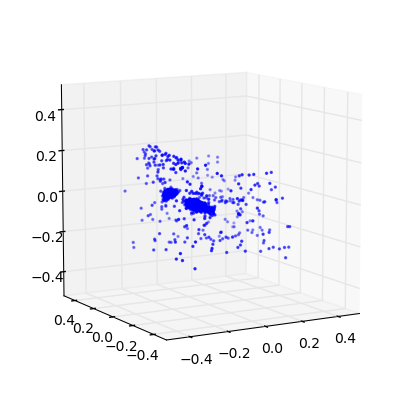

551 (0.42964564885782158, 2.5375749432522317) 28.1054849625
552 (0.57838054273439488, 2.4924621125926141) 28.0657219887
553 (0.64566948776659761, 2.5907794999039693) 28.3779098988
554 (0.47552326399347056, 2.3362816727679707) 28.0806598663
555 (0.53771376078543454, 2.5483668179615684) 28.096362114
556 (0.55105241511179048, 2.3853671877280527) 28.3410179615
557 (0.57342424742553544, 2.4989755928516386) 28.0947289467
558 (0.56943078274312231, 2.2472322712773862) 28.5051329136
559 (0.54658353121384329, 2.4991464000681174) 28.5566430092
560 (0.53403329382772036, 2.2325699619624926) 28.4353909492
561 (0.50678691902886264, 2.4683624581150387) 28.1836218834
562 (0.59253631622894953, 2.2931459494259046) 28.4314081669
563 (0.52827587231345796, 2.3041092084801718) 28.2098209858
564 (0.53489990091842154, 2.8043961986251498) 28.2392258644
565 (0.52673405097878501, 2.6507848407911219) 28.2367801666
566 (0.55011108375113948, 2.5409884318061495) 28.2215840816
567 (0.48908900437147723, 2.5158525705337

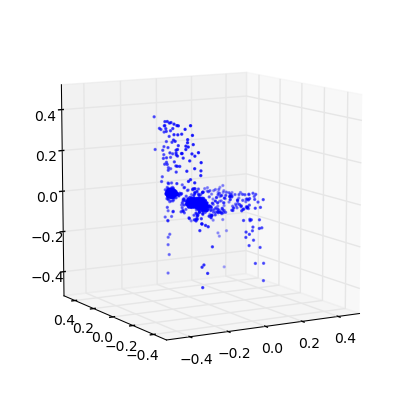

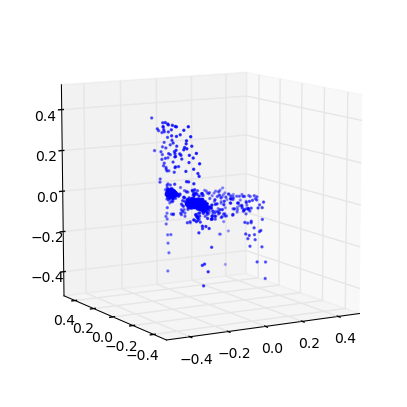

601 (0.36012406906355982, 2.6945148208866949) 28.1805489063
602 (0.35606687373441198, 2.8554697606874551) 28.2861390114
603 (0.43964613676071168, 2.6679018652957418) 28.4161949158
604 (0.36344205322472944, 2.677557427468507) 28.476736784
605 (0.33317361279674196, 2.6691103489502614) 28.3446929455
606 (0.31440168217472408, 2.8121408545452615) 28.6185770035
607 (0.36098723372687463, 2.7776022107704827) 27.9586780071
608 (0.39203209721523785, 2.6670514262240865) 26.7462601662
609 (0.29214684496755183, 2.7594112479168436) 26.9225640297
610 (0.33348851851795031, 2.7896119091821752) 27.0940511227
611 (0.33251870676227235, 2.9948246178419695) 26.9374620914
612 (0.32742014916046808, 3.3395281957543417) 26.5759010315
613 (0.28834105451469838, 2.8976405444352524) 26.578720808
614 (0.36251507401466371, 2.8290112739023954) 26.733394146
615 (0.32607924497645835, 2.8030975041182145) 26.7453119755
616 (0.31514208640741265, 3.2087968701901644) 27.0068061352
617 (0.30347159945446511, 3.3641343925310219

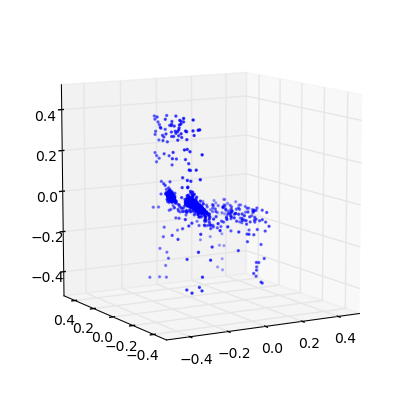

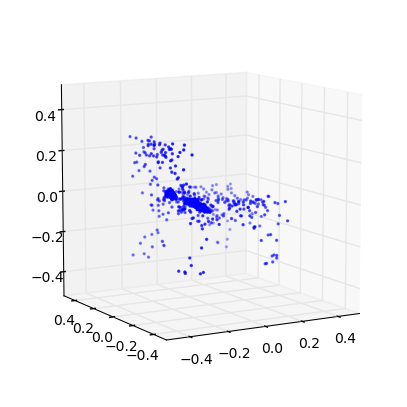

651 (0.32547429424265156, 2.7899277614510578) 26.9004881382
652 (0.28941687125226728, 3.1391376101452373) 26.9899480343
653 (0.25621032760195112, 3.0236203504645305) 26.7464921474
654 (0.33149516854597172, 3.208205495191657) 26.8473739624
655 (0.43988142745650333, 3.5714268149241155) 26.7647218704
656 (0.29092788456574731, 3.2102880343146944) 26.8003408909
657 (0.27270209737446, 3.2182887823685355) 26.7531878948
658 (0.27740947170102076, 3.2395811319351195) 26.5638308525
659 (0.42276697226840515, 3.8444733808869902) 26.7148258686
660 (0.29042835792769556, 3.0623500077620798) 27.1382830143
661 (0.32272752827924228, 3.3510818108268405) 26.558480978
662 (0.34230206161737442, 2.9031724318214085) 26.7066969872
663 (0.33034820375235185, 2.9424302847489066) 26.8650970459
664 (0.32532064629637675, 3.1378393789996273) 26.7404530048
665 (0.34387270121470742, 3.1526130178700322) 26.7219910622
666 (0.30557726368955945, 3.3478308345960532) 26.8329570293
667 (0.26841415879519087, 3.2161474766938585)

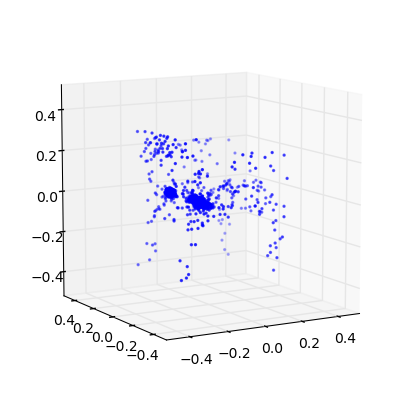

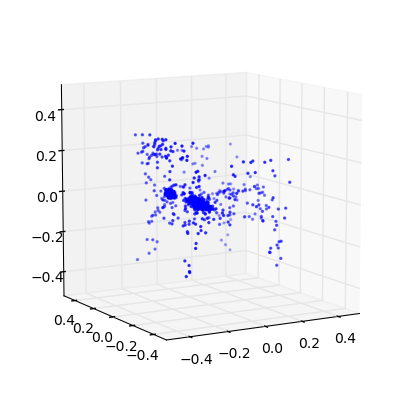

701 (0.41688162658525552, 3.1187963506449825) 26.5907490253
702 (0.28962245946345122, 2.8912756805834561) 26.5897090435
703 (0.28898101138032001, 3.4120770558066988) 26.4929430485
704 (0.27549984688344209, 3.6455918477929159) 26.4971339703
705 (0.30431414829648057, 3.6584613271381543) 26.4864640236
706 (0.28665886268667551, 3.7728757339975107) 26.4879858494
707 (0.28897621767676396, 3.8109281788701597) 26.4900979996
708 (0.24269932450159737, 3.5416998759559961) 26.4426550865
709 (0.21361274087558621, 3.5999899833098703) 26.4658448696
710 (0.27784052083025806, 3.9058457612991333) 26.4719099998
711 (0.23673924515428751, 3.526907700041066) 26.5143737793
712 (0.39415706846377124, 4.2488144633562666) 26.4788069725
713 (0.42044083032271135, 3.6339573943096659) 26.4487850666
714 (0.26345330049162324, 3.0322653231413468) 48.6467859745
715 (0.279145840263885, 3.0132242420445317) 55.5201201439
716 (0.29803902098666069, 3.2380620064942733) 55.5093109608
717 (0.22653750388518623, 3.463868006415989

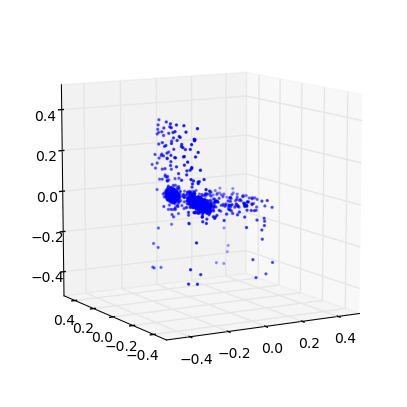

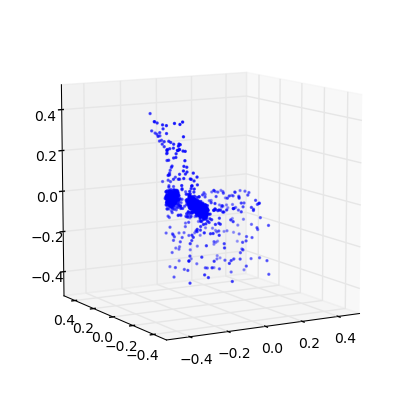

751 (0.42458136587039286, 3.3867504371249155) 26.4347801208
752 (0.3098207908480064, 3.1140858930090198) 26.4498989582
753 (0.29524260383585227, 3.2777072108310201) 26.4972379208
754 (0.37159768459589587, 3.3332555651664735) 26.4571039677
755 (0.28251621956410616, 2.976129548445992) 26.661108017
756 (0.28323798380468201, 3.2117358477219291) 26.6323580742
757 (0.3509091117459795, 3.7230931406435759) 26.8221619129
758 (0.33331539779901503, 3.0456497099088584) 26.6194729805
759 (0.26769575638615567, 3.1606257511221845) 26.9067108631
760 (0.27198164158541221, 3.2889635127523671) 26.746201992
761 (0.36537670564392338, 3.8544122566347538) 27.0340228081
762 (0.44136351904143456, 4.1637573218863944) 26.7988409996
763 (0.29695458606533381, 3.3894066820973934) 27.0184059143
764 (0.28242363113424052, 3.2314133291659148) 27.2030119896
765 (0.28574288493913153, 3.1349897778552513) 27.0418241024
766 (0.26784153110955072, 3.4469793672147007) 26.9653110504
767 (0.21357540854293366, 3.4302369283593221)

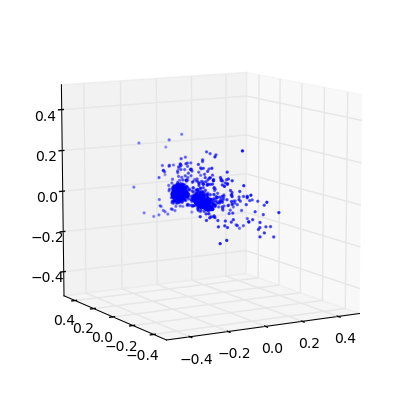

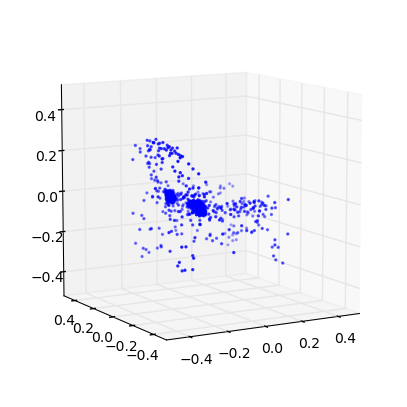

801 (0.29326033248849537, 3.2213456827661267) 26.7160840034
802 (0.28272405674924023, 3.2765177452045937) 26.9592530727
803 (0.37777379828950636, 3.7066892266273497) 27.0003840923
804 (0.25888637135858122, 3.5338808598725691) 26.907045126
805 (0.31553527414798738, 3.3401512425878774) 27.0030210018
806 (0.31706126358198083, 3.5354443104370779) 26.8333280087
807 (0.26729923966138258, 3.3206537692443185) 26.9760859013
808 (0.27821887900000031, 3.5021039734716002) 27.0129320621
809 (0.21881151186383288, 3.6152431871580042) 26.9611520767
810 (0.19488357282851054, 3.6240829104962557) 26.8403229713
811 (0.23234105971844299, 3.8728281788204026) 27.0387160778
812 (0.40596567295167757, 3.8499659820743228) 27.0911700726
813 (0.32548357060422067, 3.4710663479307424) 27.1182141304
814 (0.33327598733746489, 3.4810051275336225) 26.7823708057
815 (0.31984540962654612, 3.1133069453032118) 27.2307469845
816 (0.3820252791694973, 3.1317438187806501) 27.2526569366
817 (0.29500792855801788, 3.17520583608876

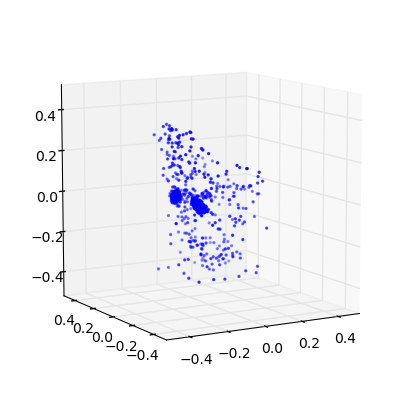

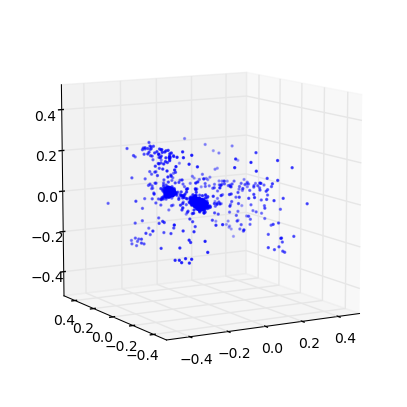

851 (0.29534705712095549, 4.3452617292818818) 26.6362040043
852 (0.28052937343068746, 3.8655232030412425) 26.9282069206
853 (0.33921027876760651, 4.0217672249545222) 26.8068449497
854 (0.25857732807812484, 4.2088072745696357) 27.0303668976
855 (0.24833168387413024, 3.9074724788251132) 26.9340288639
856 (0.21597023975590002, 3.7618551720743594) 26.5470628738
857 (0.22498788548552473, 3.7135649307914402) 26.6893439293
858 (0.27074014946170477, 4.2107766203258352) 26.7141139507
859 (0.39779386319544002, 4.57169778994892) 26.9796230793
860 (0.26137415248414747, 4.0533993824668553) 26.6591649055
861 (0.22702204798874648, 3.8699665567149286) 26.9497637749
862 (0.22793676895291909, 3.643058365324269) 26.8223068714
863 (0.26921530942554062, 4.603673033092333) 26.92085886
864 (0.16496294675313908, 4.4620676247969921) 26.5598199368
865 (0.20289905655967153, 4.8092951359956162) 26.7402889729
866 (0.20844801065066587, 4.3718740732773487) 26.7848758698
867 (0.44137059757081065, 4.7514455849709716) 

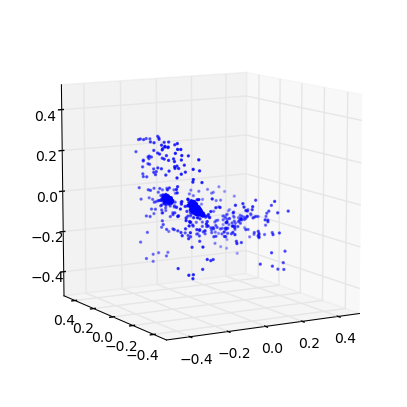

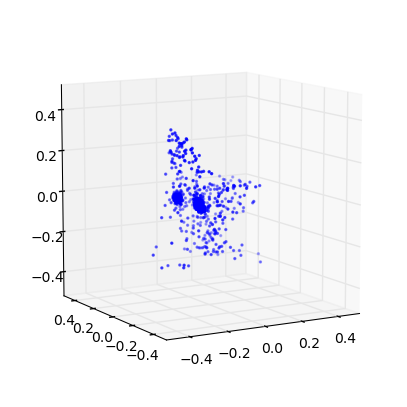

901 (0.21232583619978118, 3.6534612976986427) 26.6240758896
902 (0.30169381345419782, 4.4922728735467663) 26.7043819427
903 (0.18402480819950934, 3.8964850094007408) 26.7234680653
904 (0.2028758758760017, 4.0629460562830388) 26.633202076
905 (0.19622974641945051, 3.8816286522409191) 26.8295538425
906 (0.2098385169454243, 3.8773186828779136) 26.5658969879
907 (0.20387065617934516, 3.9015261608621348) 26.7964401245
908 (0.19636615624894266, 4.2248834941698155) 26.6900207996
909 (0.19642251193847346, 4.2908061742782593) 27.0066618919
910 (0.33259410769071268, 4.938134026527405) 26.6847670078
911 (0.17409623219915057, 3.785649910180465) 26.6497168541
912 (0.22202609770971796, 3.6873249997263371) 26.7643749714
913 (0.31430664736291636, 4.2668238292569702) 26.713255167
914 (0.28044925986424735, 3.8663481717524322) 27.0464451313
915 (0.21526087062514346, 3.6416583071584285) 26.7269790173
916 (0.21727524911579879, 3.5731214730635932) 26.7708058357
917 (0.33650497709927352, 4.6883746468502538) 

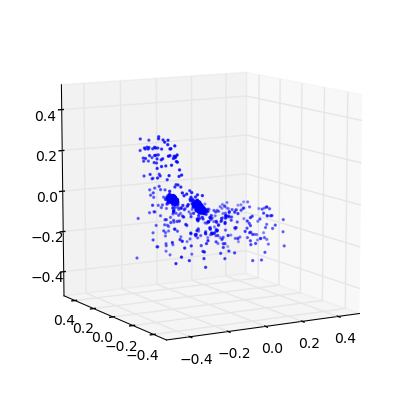

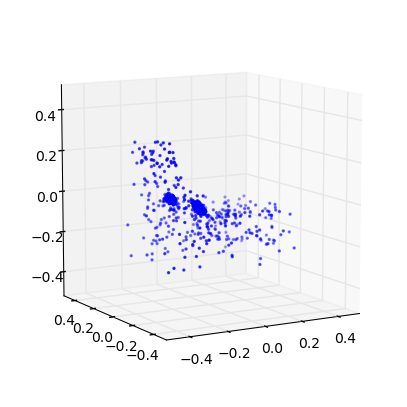

951 (0.56040354192904807, 5.2634216256763624) 26.8721399307
952 (0.43992122136380363, 4.3507203954717388) 26.7782108784
953 (0.34320632455789524, 4.0741947899694031) 26.7200820446
954 (0.26871869369693424, 3.5453370996143505) 26.7874088287
955 (0.20661696247432543, 3.4894510683806046) 26.6605889797
956 (0.24739862683674563, 3.8623243762099224) 26.7810969353
957 (0.3495839938197447, 4.6533126385315606) 26.7037770748
958 (0.21476312566386616, 4.0074712618537571) 27.4129388332
959 (0.24688777748657309, 3.6687257828919786) 26.6662700176
960 (0.38003700019224829, 4.6245667048122572) 26.7860379219
961 (0.20063280806593273, 3.5070471514826234) 26.6989979744
962 (0.21365163799213327, 3.9232386008552882) 27.1375591755
963 (0.3790481624395951, 4.5628503965294875) 27.207103014
964 (0.23779079045938409, 3.7851329233335411) 27.2401230335
965 (0.21502150306883067, 4.3380431558774868) 27.1768009663
966 (0.23823923954497214, 4.1583619382070456) 26.8017418385
967 (0.26545962513141008, 4.151812147057574

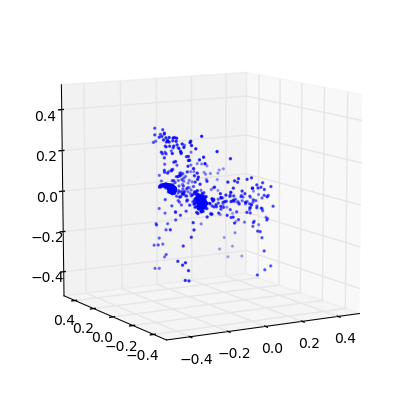

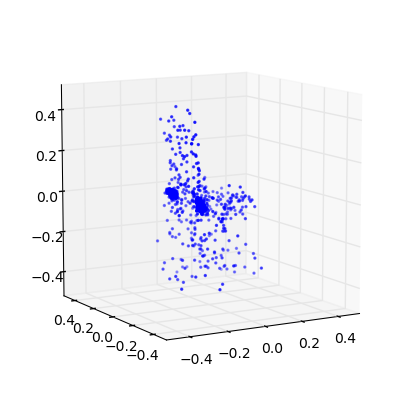

1001 (0.20021580616417139, 3.8635697872742361) 27.520583868
1002 (0.21805344016655631, 4.3047128013942553) 26.8430840969
1003 (0.391686380363029, 4.7751682297043176) 26.7934911251
1004 (0.31394162375641904, 4.4281163132709009) 27.0380930901
1005 (0.29289395715231481, 4.4729557477909587) 26.7073709965
1006 (0.35376320371161335, 4.5992056364598479) 27.1448171139
1007 (0.34800474689058636, 4.5883578551852189) 27.1189010143
1008 (0.25041446407204088, 3.8358240625132685) 27.2420761585
1009 (0.22170094041072805, 3.3427144931710284) 27.7311840057
1010 (0.196251628904239, 3.4055563055950664) 27.0170829296
1011 (0.2027418116512506, 3.5759106781171717) 27.0425670147
1012 (0.21665866455954055, 4.0018600401671041) 27.1660671234
1013 (0.16670811069400415, 3.7414316706035446) 27.1328959465
1014 (0.18861599143432534, 3.761516673668571) 26.9420199394
1015 (0.44159273122963699, 4.5393191837098286) 27.1526248455
1016 (0.1851348059332889, 4.318907496203547) 26.9652760029
1017 (0.1674761283332887, 4.17435

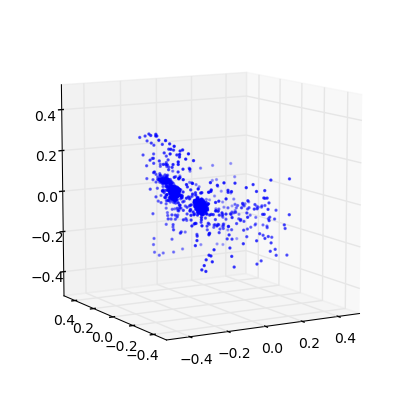

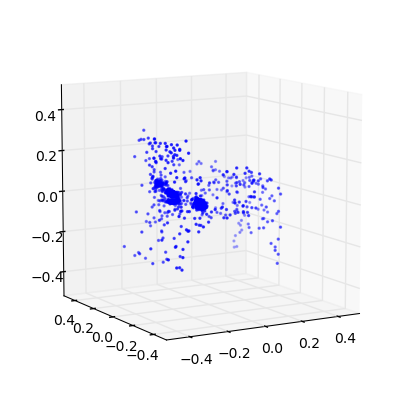

1051 (0.23486232096734255, 3.6903141426003496) 27.0364329815
1052 (0.32380953110430549, 4.5044793802758925) 27.0457820892
1053 (0.21083843290157941, 3.8433170038720834) 27.1385350227
1054 (0.2726985085917556, 3.9858378451803458) 27.7008569241
1055 (0.41082570201352886, 5.1038425637328109) 26.9680659771
1056 (0.26388448220880134, 4.4149123689402705) 27.1122000217
1057 (0.16279562585379767, 4.3565609506938765) 26.9410498142
1058 (0.15643798488637675, 4.1284197123154351) 26.9761860371
1059 (0.20980349286742833, 4.3163489124049308) 27.0896711349
1060 (0.17803157595512659, 4.1137833854426509) 26.9615249634
1061 (0.1675237344496924, 4.2040285017179402) 26.9625940323
1062 (0.24852313786421132, 5.1144740379374962) 26.8866591454
1063 (0.18051635496642279, 4.5810025774914287) 26.938477993
1064 (0.13972962939220926, 4.0406938843105147) 26.9024019241
1065 (0.19079224057495595, 4.5879701966824742) 26.9125421047
1066 (0.1782561643777982, 4.5334497866423238) 27.0000321865
1067 (0.22097032497758451, 4

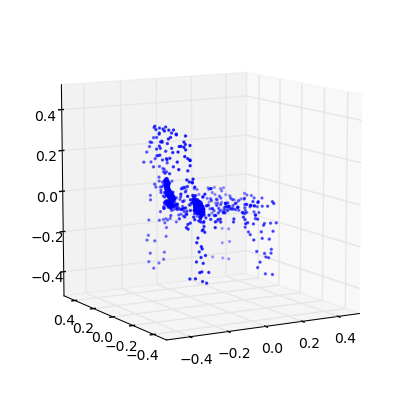

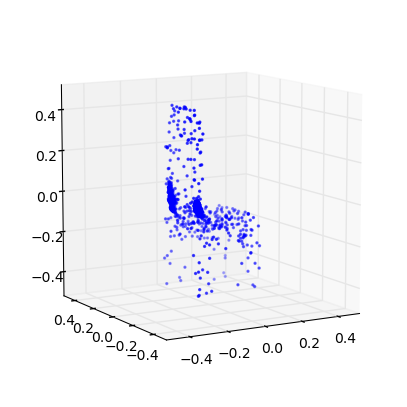

1101 (0.28028223106394645, 4.201235268426978) 26.8986589909
1102 (0.20503853565972785, 3.669439241160517) 27.4773070812
1103 (0.21156397695126741, 3.7677486668462339) 27.6695690155
1104 (0.21254294323532477, 4.0622647824494731) 26.9288771152
1105 (0.24320830709260444, 4.2325906224872751) 27.4522809982
1106 (0.19829249301034471, 3.8191409422003706) 27.1900000572
1107 (0.30042943377857623, 4.0869918683300845) 27.2296419144
1108 (0.20365096288530724, 3.9221419292947521) 27.2459590435
1109 (0.21286344761433809, 4.0226283197817594) 27.2367119789
1110 (0.25974570477138392, 4.3681669007176938) 27.1220338345
1111 (0.18511895722021227, 4.1742957457252174) 27.6192200184
1112 (0.19825987845011381, 4.3850133076958038) 27.1704690456
1113 (0.20281721557612004, 4.1279432193092678) 27.3182849884
1114 (0.31830313720780873, 4.3802345807137693) 27.0599219799
1115 (0.4198305983906207, 4.7487727372542672) 27.4957330227
1116 (0.23819673317282097, 4.0927153991616292) 27.1455299854
1117 (0.36578878368372503, 

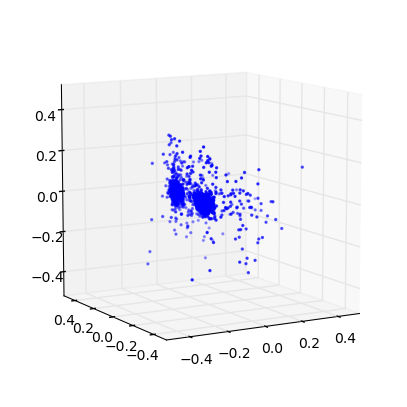

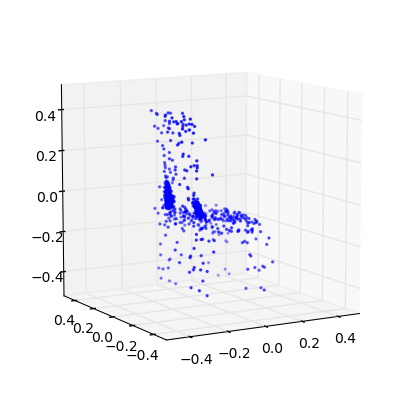

1151 (0.20614736753961313, 4.6756214338800177) 27.2296919823
1152 (0.25564717728158703, 4.7551378960194794) 27.3243858814
1153 (0.19997977795808211, 3.9561889959418255) 27.1970870495
1154 (0.24508909391968148, 4.6867082481798921) 27.1701951027
1155 (0.19205662774974885, 4.5725133076958038) 27.4734649658
1156 (0.18810734410324823, 4.5419907445492953) 26.9604699612
1157 (0.14524330109681771, 4.3125218930451767) 26.8259699345
1158 (0.25536346754626088, 4.8966579395791756) 27.7537331581
1159 (0.17398799346840899, 4.471696875406348) 27.1888961792
1160 (0.15190093426600745, 4.3561065984808884) 27.091356039
1161 (0.25058915025514106, 5.2913746823435241) 27.0692539215
1162 (0.18940453722101191, 4.503176832199097) 26.9856939316
1163 (0.15528482674904492, 4.3799642459205961) 27.6179161072
1164 (0.12472731913237468, 4.2913592462954311) 27.4353311062
1165 (0.15673176459968091, 4.3751561019731602) 27.1802608967
1166 (0.35030511511570733, 5.5891477740329245) 27.237293005
1167 (0.15199082224913266, 4

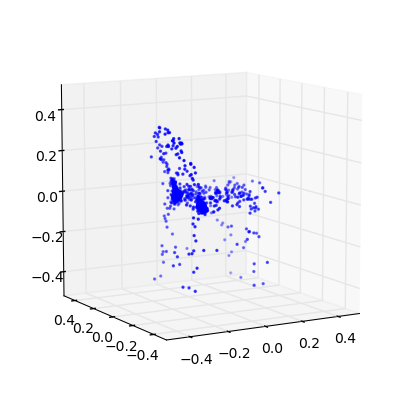

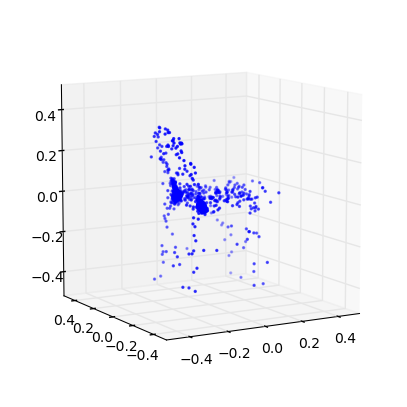

1201 (0.15061120050756827, 5.5147610695465747) 26.9465520382
1202 (0.12710815882715193, 5.8087485748788588) 27.1488249302
1203 (0.084821626357734201, 5.3859032921169119) 27.0722970963
1204 (0.092178488004466763, 5.1872106116750967) 27.1327030659
1205 (0.10138559965821711, 5.1809928976971173) 27.1438550949
1206 (0.21776815117944193, 6.5440564533938534) 27.3897800446
1207 (0.11346938162232223, 5.2014121874519015) 27.5708789825
1208 (0.092516352592603018, 5.1912762890691342) 26.9223070145
1209 (0.086067128302934379, 5.0819588785586154) 27.3992190361
1210 (0.056066011218354105, 5.2201645187709644) 27.1366817951
1211 (0.069398122151260788, 5.3296126427857775) 27.1619648933
1212 (0.11350410716689151, 5.5483228227366572) 27.3783299923
1213 (0.2378615316975376, 7.2502713856489764) 27.334815979
1214 (0.17254615387190944, 6.479542593334032) 27.020608902
1215 (0.23242773509624859, 5.7198751387388809) 27.3198969364
1216 (0.19192107630812605, 4.8238226144210152) 26.921328783
1217 (0.303762845338686

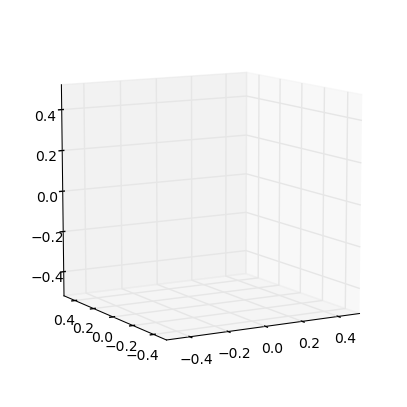

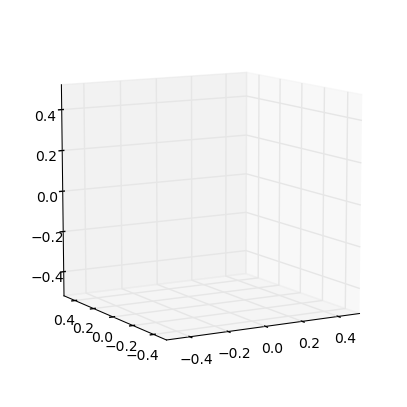

1251 (nan, nan) 25.6745240688
1252 (nan, nan) 25.4702432156
1253 (nan, nan) 25.66320014
1254 (nan, nan) 25.603718996
1255 (nan, nan) 25.6003448963
1256 (nan, nan) 25.4575719833
1257 (nan, nan) 25.4929368496
1258 (nan, nan) 25.5325198174
1259 (nan, nan) 25.5736188889
1260 (nan, nan) 25.4682779312
1261 (nan, nan) 25.5166358948
1262 (nan, nan) 25.5554060936
1263 (nan, nan) 25.5498068333
1264 (nan, nan) 25.6864278316
1265 (nan, nan) 25.7800958157
1266 (nan, nan) 25.4979608059
1267 (nan, nan) 25.5399320126
1268 (nan, nan) 25.5454249382
1269 (nan, nan) 25.7470610142
1270 (nan, nan) 25.5476398468
1271 (nan, nan) 25.4847209454
1272 (nan, nan) 25.4838869572
1273 (nan, nan) 25.5377631187
1274 (nan, nan) 25.4746148586
1275 (nan, nan) 25.4354650974
1276 (nan, nan) 25.6680669785
1277 (nan, nan) 25.4860479832
1278 (nan, nan) 25.6622400284
1279 (nan, nan) 25.5657510757
1280 (nan, nan) 25.5120182037
1281 (nan, nan) 25.6096839905
1282 (nan, nan) 25.8401939869
1283 (nan, nan) 25.550976038
1284 (nan, nan

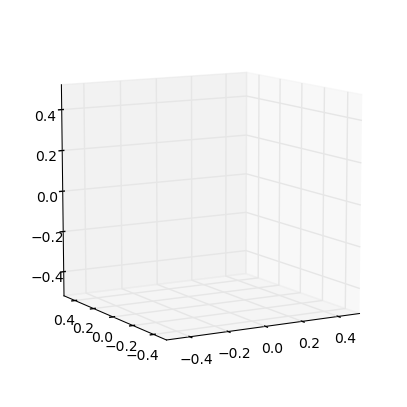

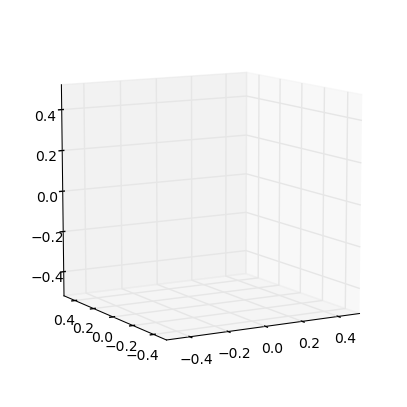

1301 (nan, nan) 25.7571499348
1302 (nan, nan) 25.4385309219
1303 (nan, nan) 25.648250103
1304 (nan, nan) 25.7320158482
1305 (nan, nan) 25.8074572086
1306 (nan, nan) 25.4495859146
1307 (nan, nan) 25.5678770542
1308 (nan, nan) 25.441724062
1309 (nan, nan) 25.581277132
1310 (nan, nan) 25.595528841
1311 (nan, nan) 25.6055049896
1312 (nan, nan) 25.4942669868
1313 (nan, nan) 25.5087969303
1314 (nan, nan) 25.6938691139
1315 (nan, nan) 25.7728278637
1316 (nan, nan) 25.4972059727
1317 (nan, nan) 25.4474060535
1318 (nan, nan) 25.5595118999
1319 (nan, nan) 25.469963789
1320 (nan, nan) 25.44790411
1321 (nan, nan) 25.4099171162
1322 (nan, nan) 25.4608800411
1323 (nan, nan) 25.4568839073
1324 (nan, nan) 25.3945147991
1325 (nan, nan) 25.5385429859
1326 (nan, nan) 25.5048840046
1327 (nan, nan) 25.4882249832
1328 (nan, nan) 25.4798049927
1329 (nan, nan) 25.5047569275
1330 (nan, nan) 25.642277956
1331 (nan, nan) 25.430366993
1332 (nan, nan) 25.4512591362
1333 (nan, nan) 25.5985751152
1334 (nan, nan) 25.

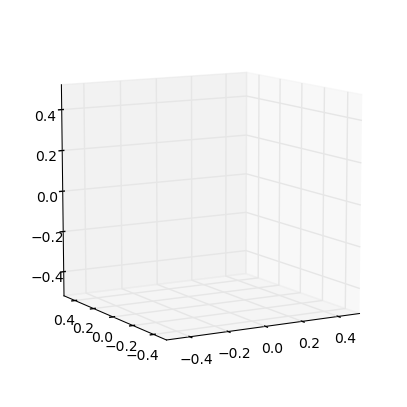

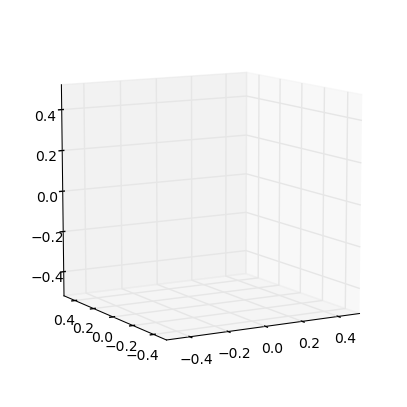

1351 (nan, nan) 25.5016069412
1352 (nan, nan) 25.3591010571
1353 (nan, nan) 25.4807519913
1354 (nan, nan) 25.61729002
1355 (nan, nan) 25.3785049915
1356 (nan, nan) 25.6176629066
1357 (nan, nan) 25.569630146
1358 (nan, nan) 25.4306130409
1359 (nan, nan) 25.3876640797
1360 (nan, nan) 25.5222439766
1361 (nan, nan) 25.6076841354
1362 (nan, nan) 25.3872580528
1363 (nan, nan) 25.4311718941
1364 (nan, nan) 25.8516221046
1365 (nan, nan) 25.6726601124
1366 (nan, nan) 25.388420105
1367 (nan, nan) 25.4603459835
1368 (nan, nan) 25.5715401173
1369 (nan, nan) 25.5510649681
1370 (nan, nan) 25.5268499851
1371 (nan, nan) 25.5083899498
1372 (nan, nan) 25.5225119591
1373 (nan, nan) 25.4796969891
1374 (nan, nan) 25.5833051205
1375 (nan, nan) 25.5416841507
1376 (nan, nan) 25.8590431213
1377 (nan, nan) 25.543022871
1378 (nan, nan) 25.6274499893
1379 (nan, nan) 25.3614499569
1380 (nan, nan) 25.5007331371
1381 (nan, nan) 25.5360479355
1382 (nan, nan) 25.4216139317
1383 (nan, nan) 25.4391920567
1384 (nan, nan)

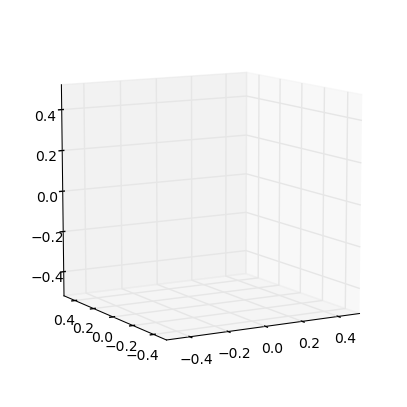

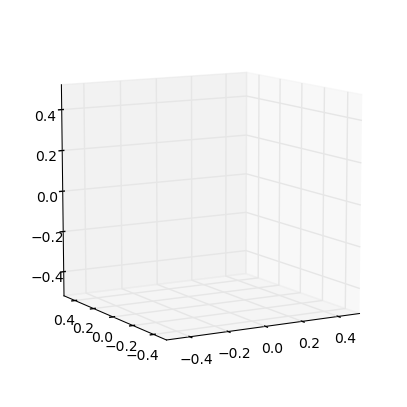

1401 (nan, nan) 25.5026071072
1402 (nan, nan) 25.4181408882
1403 (nan, nan) 25.5606229305
1404 (nan, nan) 25.5438630581
1405 (nan, nan) 25.3949639797
1406 (nan, nan) 25.4209010601
1407 (nan, nan) 25.4377250671
1408 (nan, nan) 25.4335319996
1409 (nan, nan) 25.4388780594
1410 (nan, nan) 25.423582077
1411 (nan, nan) 25.765239954
1412 (nan, nan) 25.8836047649
1413 (nan, nan) 25.6493558884
1414 (nan, nan) 25.7475919724
1415 (nan, nan) 26.0075538158
1416 (nan, nan) 25.9618120193
1417 (nan, nan) 25.8719220161
1418 (nan, nan) 26.0926039219
1419 (nan, nan) 26.1325881481
1420 (nan, nan) 26.1026160717
1421 (nan, nan) 26.6068849564
1422 (nan, nan) 26.215927124
1423 (nan, nan) 25.9637260437
1424 (nan, nan) 26.1641430855
1425 (nan, nan) 26.217291832
1426 (nan, nan) 25.8970830441
1427 (nan, nan) 26.7739131451
1428 (nan, nan) 25.7411339283
1429 (nan, nan) 26.4751081467
1430 (nan, nan) 26.129117012
1431 (nan, nan) 26.3622810841
1432 (nan, nan) 26.1415719986
1433 (nan, nan) 26.0764100552
1434 (nan, nan)

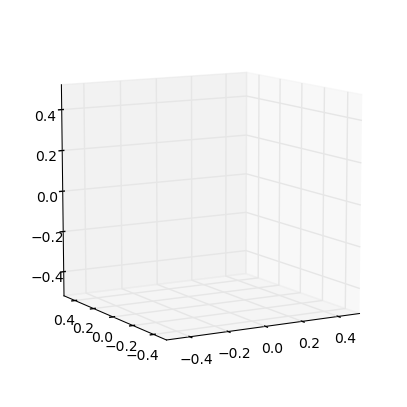

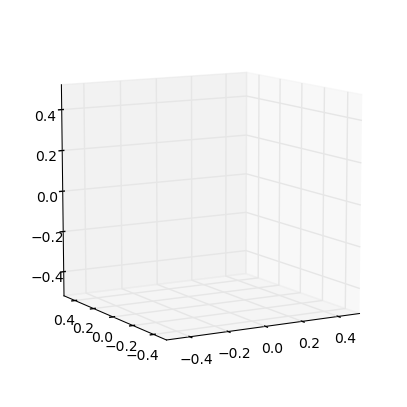

1451 (nan, nan) 25.7572438717
1452 (nan, nan) 26.3478860855
1453 (nan, nan) 26.0211789608
1454 (nan, nan) 26.5941479206
1455 (nan, nan) 26.1196789742
1456 (nan, nan) 26.1498639584
1457 (nan, nan) 26.1335608959
1458 (nan, nan) 26.4030981064
1459 (nan, nan) 26.3327429295
1460 (nan, nan) 26.2388460636
1461 (nan, nan) 26.2432730198
1462 (nan, nan) 26.3580460548
1463 (nan, nan) 26.1674950123
1464 (nan, nan) 26.1530489922
1465 (nan, nan) 26.5210101604
1466 (nan, nan) 26.3741071224
1467 (nan, nan) 25.8998599052
1468 (nan, nan) 26.4398801327
1469 (nan, nan) 26.0861799717
1470 (nan, nan) 25.8585071564
1471 (nan, nan) 26.2064070702
1472 (nan, nan) 26.3038640022
1473 (nan, nan) 25.9262170792
1474 (nan, nan) 26.1208798885
1475 (nan, nan) 26.1136548519
1476 (nan, nan) 26.052273035
1477 (nan, nan) 26.1556169987
1478 (nan, nan) 26.4320290089
1479 (nan, nan) 26.3884868622
1480 (nan, nan) 26.1495149136
1481 (nan, nan) 26.1926259995
1482 (nan, nan) 26.2038881779
1483 (nan, nan) 26.2964949608
1484 (nan, 

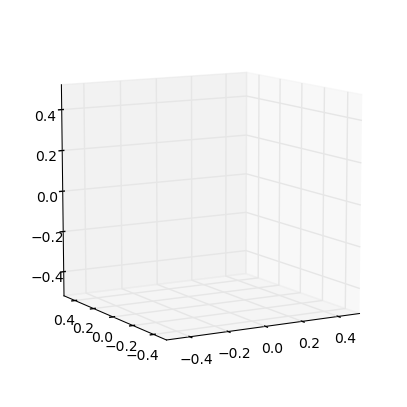

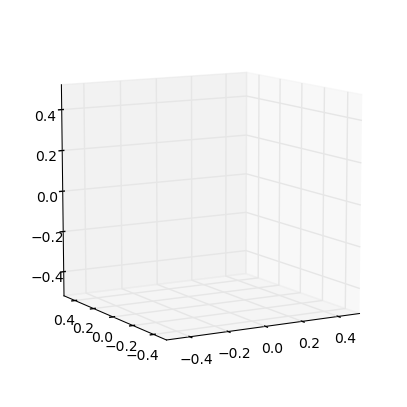

1501 (nan, nan) 25.7547111511
1502 (nan, nan) 26.4654319286
1503 (nan, nan) 25.7860081196
1504 (nan, nan) 26.2722370625
1505 (nan, nan) 26.3918731213
1506 (nan, nan) 25.7463190556
1507 (nan, nan) 26.2753489017
1508 (nan, nan) 25.9682481289
1509 (nan, nan) 26.2955210209
1510 (nan, nan) 26.0261240005
1511 (nan, nan) 26.1583640575
1512 (nan, nan) 25.9172968864
1513 (nan, nan) 26.0625429153
1514 (nan, nan) 26.3981628418
1515 (nan, nan) 26.4069731236
1516 (nan, nan) 25.8516821861
1517 (nan, nan) 26.6816318035
1518 (nan, nan) 25.90863204
1519 (nan, nan) 25.9764008522
1520 (nan, nan) 26.506816864
1521 (nan, nan) 25.8762280941
1522 (nan, nan) 26.1501982212
1523 (nan, nan) 26.1352870464
1524 (nan, nan) 26.2482149601
1525 (nan, nan) 26.1667261124
1526 (nan, nan) 26.0882499218
1527 (nan, nan) 26.5942399502
1528 (nan, nan) 26.0087709427
1529 (nan, nan) 26.4110431671
1530 (nan, nan) 26.2959690094
1531 (nan, nan) 25.9256441593
1532 (nan, nan) 26.0715739727
1533 (nan, nan) 26.0959501266
1534 (nan, na

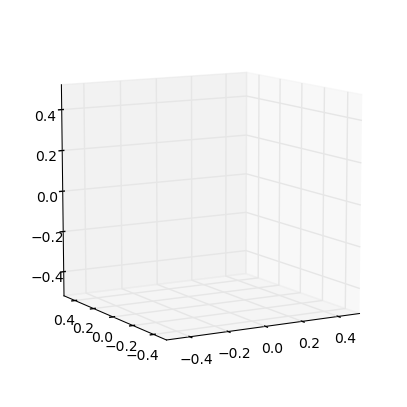

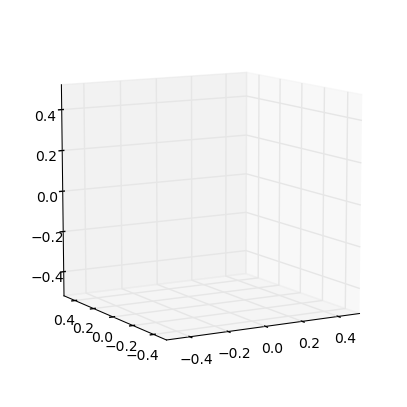

1551 (nan, nan) 26.3103721142
1552 (nan, nan) 26.3440351486
1553 (nan, nan) 26.1355969906
1554 (nan, nan) 26.4982919693
1555 (nan, nan) 26.2003779411
1556 (nan, nan) 25.8109769821
1557 (nan, nan) 26.6783130169
1558 (nan, nan) 26.1878180504
1559 (nan, nan) 26.3020608425
1560 (nan, nan) 26.0152468681
1561 (nan, nan) 26.6025738716
1562 (nan, nan) 25.875453949
1563 (nan, nan) 26.6357638836
1564 (nan, nan) 26.2455129623
1565 (nan, nan) 26.3157041073
1566 (nan, nan) 26.0057859421
1567 (nan, nan) 26.3985991478
1568 (nan, nan) 26.3614151478
1569 (nan, nan) 26.4613180161
1570 (nan, nan) 26.1253008842
1571 (nan, nan) 26.5907599926
1572 (nan, nan) 26.1631247997
1573 (nan, nan) 26.0625479221
1574 (nan, nan) 26.1716852188
1575 (nan, nan) 26.3040578365
1576 (nan, nan) 25.9570658207
1577 (nan, nan) 26.2323579788
1578 (nan, nan) 26.7964160442
1579 (nan, nan) 26.588447094
1580 (nan, nan) 26.5019960403
1581 (nan, nan) 26.4464669228
1582 (nan, nan) 26.7181100845
1583 (nan, nan) 26.6051769257
1584 (nan, n

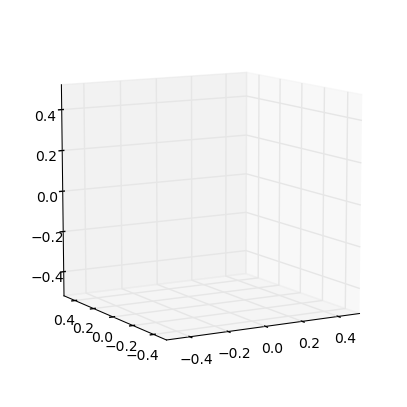

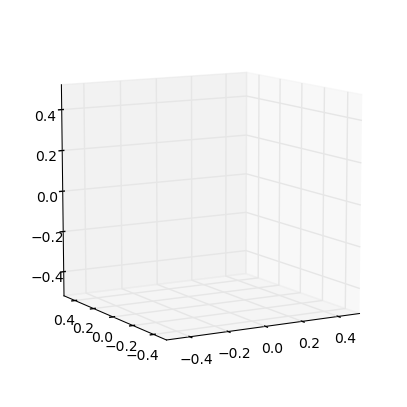

1601 (nan, nan) 26.7637591362
1602 (nan, nan) 26.4525849819
1603 (nan, nan) 26.5487859249
1604 (nan, nan) 26.5335569382
1605 (nan, nan) 26.5228550434
1606 (nan, nan) 26.4618179798
1607 (nan, nan) 26.4382929802
1608 (nan, nan) 26.7659268379
1609 (nan, nan) 26.4732658863
1610 (nan, nan) 26.5449619293
1611 (nan, nan) 26.4435610771
1612 (nan, nan) 26.4777848721
1613 (nan, nan) 26.3561360836
1614 (nan, nan) 26.4994261265
1615 (nan, nan) 26.3601610661
1616 (nan, nan) 26.5583870411
1617 (nan, nan) 26.5611200333
1618 (nan, nan) 26.5211160183
1619 (nan, nan) 26.6085472107
1620 (nan, nan) 26.6853320599
1621 (nan, nan) 26.465875864
1622 (nan, nan) 26.4366090298
1623 (nan, nan) 26.5226340294
1624 (nan, nan) 26.693239212
1625 (nan, nan) 26.6865389347
1626 (nan, nan) 26.3939361572
1627 (nan, nan) 26.5277848244
1628 (nan, nan) 26.8918509483
1629 (nan, nan) 26.6359601021
1630 (nan, nan) 26.6507129669
1631 (nan, nan) 26.581043005
1632 (nan, nan) 26.6312201023
1633 (nan, nan) 26.5942368507
1634 (nan, na

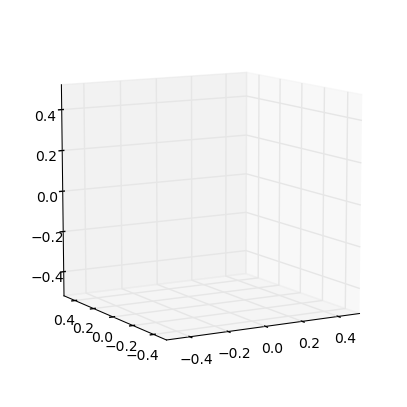

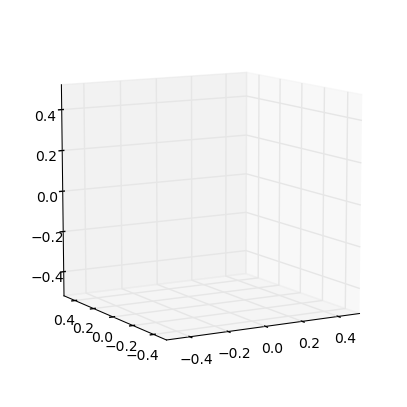

1651 (nan, nan) 26.8374209404
1652 (nan, nan) 26.543628931
1653 (nan, nan) 26.4922440052
1654 (nan, nan) 26.6401519775
1655 (nan, nan) 26.6193928719
1656 (nan, nan) 26.5925199986
1657 (nan, nan) 26.5465300083
1658 (nan, nan) 26.6218669415
1659 (nan, nan) 26.5195820332
1660 (nan, nan) 26.4693520069
1661 (nan, nan) 26.4878389835
1662 (nan, nan) 26.4482519627
1663 (nan, nan) 26.5974349976
1664 (nan, nan) 26.696559906
1665 (nan, nan) 26.4850151539
1666 (nan, nan) 26.6257920265
1667 (nan, nan) 26.659924984
1668 (nan, nan) 26.5352520943
1669 (nan, nan) 26.4407498837
1670 (nan, nan) 26.4453248978
1671 (nan, nan) 26.4655089378
1672 (nan, nan) 26.4234220982
1673 (nan, nan) 26.3618590832
1674 (nan, nan) 26.4877090454
1675 (nan, nan) 26.3566310406
1676 (nan, nan) 26.3850259781
1677 (nan, nan) 26.3345620632
1678 (nan, nan) 26.4710278511
1679 (nan, nan) 26.5479309559
1680 (nan, nan) 26.410061121
1681 (nan, nan) 26.5344839096
1682 (nan, nan) 26.4927179813
1683 (nan, nan) 26.5604670048
1684 (nan, nan

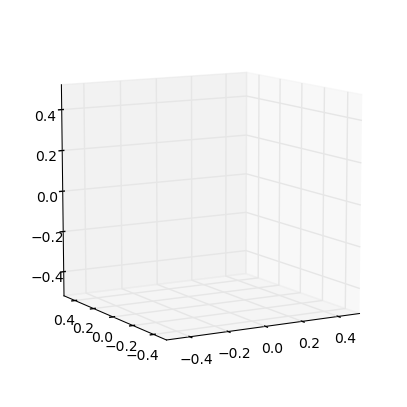

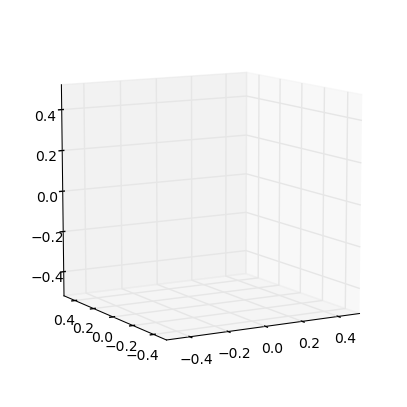

1701 (nan, nan) 26.3339760303
1702 (nan, nan) 26.3133370876
1703 (nan, nan) 26.6119909286
1704 (nan, nan) 26.365888834
1705 (nan, nan) 26.31229496
1706 (nan, nan) 26.4736988544
1707 (nan, nan) 26.5902018547
1708 (nan, nan) 26.6865801811
1709 (nan, nan) 26.4878809452
1710 (nan, nan) 26.3080091476
1711 (nan, nan) 26.4711019993
1712 (nan, nan) 26.7449679375
1713 (nan, nan) 26.4423789978
1714 (nan, nan) 26.6710851192
1715 (nan, nan) 26.9638009071
1716 (nan, nan) 26.7854380608
1717 (nan, nan) 26.8520228863
1718 (nan, nan) 26.3707859516
1719 (nan, nan) 26.3200218678
1720 (nan, nan) 26.4566979408
1721 (nan, nan) 26.8139488697
1722 (nan, nan) 26.4938890934
1723 (nan, nan) 26.7960159779
1724 (nan, nan) 26.6259858608
1725 (nan, nan) 26.3253819942
1726 (nan, nan) 26.3855450153
1727 (nan, nan) 26.3283081055
1728 (nan, nan) 26.5288119316
1729 (nan, nan) 26.4805488586
1730 (nan, nan) 26.4668819904
1731 (nan, nan) 26.3488180637
1732 (nan, nan) 26.7090950012
1733 (nan, nan) 26.4790949821
1734 (nan, na

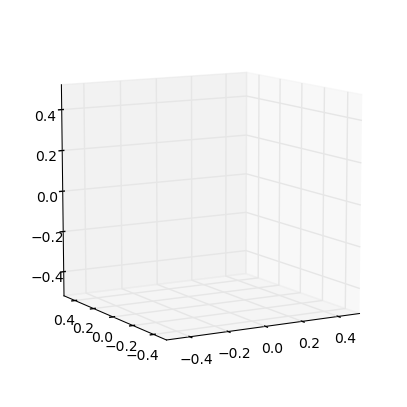

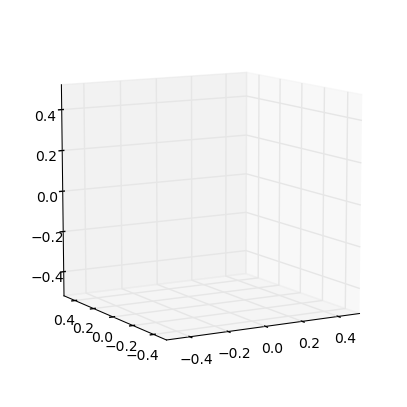

1751 (nan, nan) 25.7636649609
1752 (nan, nan) 25.664288044
1753 (nan, nan) 26.1481368542
1754 (nan, nan) 26.1635940075
1755 (nan, nan) 26.2093710899
1756 (nan, nan) 26.1209769249
1757 (nan, nan) 26.3107779026
1758 (nan, nan) 26.0517368317
1759 (nan, nan) 26.1081748009
1760 (nan, nan) 26.5778589249
1761 (nan, nan) 26.1144151688
1762 (nan, nan) 25.6553590298
1763 (nan, nan) 25.804309845
1764 (nan, nan) 26.2246768475
1765 (nan, nan) 25.9263489246
1766 (nan, nan) 26.0679318905
1767 (nan, nan) 26.0059027672
1768 (nan, nan) 25.6907939911
1769 (nan, nan) 25.9390351772
1770 (nan, nan) 26.1672620773
1771 (nan, nan) 25.810667038
1772 (nan, nan) 25.8906579018
1773 (nan, nan) 25.9616808891
1774 (nan, nan) 26.0476930141
1775 (nan, nan) 26.0167849064
1776 (nan, nan) 25.8036599159
1777 (nan, nan) 26.1368579865
1778 (nan, nan) 25.6924109459
1779 (nan, nan) 26.1992709637
1780 (nan, nan) 26.0970718861
1781 (nan, nan) 26.0949759483
1782 (nan, nan) 26.0311980247
1783 (nan, nan) 26.1744089127
1784 (nan, na

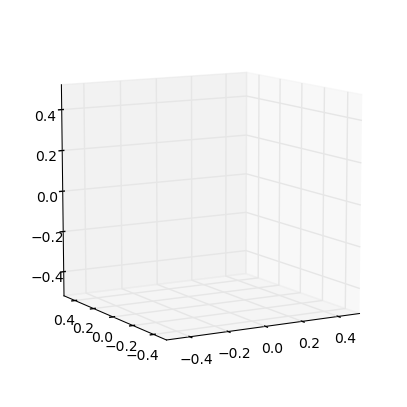

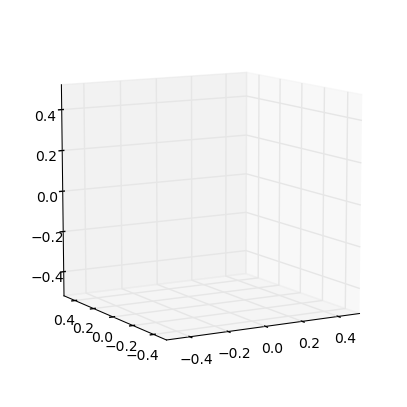

1801 (nan, nan) 25.7001059055
1802 (nan, nan) 26.2336509228
1803 (nan, nan) 26.2648649216
1804 (nan, nan) 26.3890161514
1805 (nan, nan) 26.2382061481
1806 (nan, nan) 26.1472640038
1807 (nan, nan) 26.0239169598
1808 (nan, nan) 26.3174757957
1809 (nan, nan) 26.1167960167
1810 (nan, nan) 25.9927790165
1811 (nan, nan) 26.1294188499
1812 (nan, nan) 25.9263350964
1813 (nan, nan) 26.1022069454
1814 (nan, nan) 26.0455799103
1815 (nan, nan) 26.404681921
1816 (nan, nan) 25.7709629536
1817 (nan, nan) 26.3701360226
1818 (nan, nan) 25.9822192192
1819 (nan, nan) 26.39508605
1820 (nan, nan) 25.7288448811
1821 (nan, nan) 26.3730938435
1822 (nan, nan) 26.0903849602
1823 (nan, nan) 26.22158885
1824 (nan, nan) 26.111207962
1825 (nan, nan) 26.052341938
1826 (nan, nan) 26.4525909424
1827 (nan, nan) 25.7676978111
1828 (nan, nan) 26.3226358891
1829 (nan, nan) 25.8200640678
1830 (nan, nan) 26.2518410683
1831 (nan, nan) 26.1824560165
1832 (nan, nan) 25.8821299076
1833 (nan, nan) 26.0392141342
1834 (nan, nan) 2

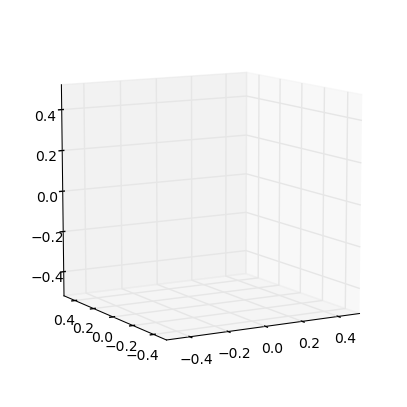

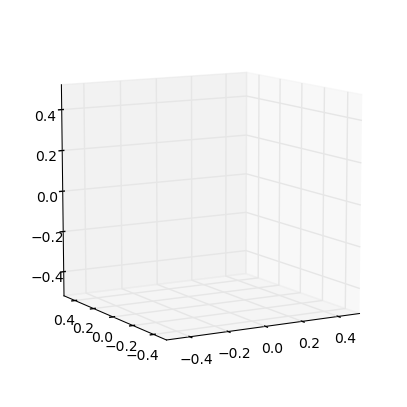

1851 (nan, nan) 25.8658759594
1852 (nan, nan) 26.0024318695
1853 (nan, nan) 25.7996180058
1854 (nan, nan) 26.2032549381
1855 (nan, nan) 25.7751028538
1856 (nan, nan) 25.9824881554
1857 (nan, nan) 25.8430581093
1858 (nan, nan) 25.8797018528
1859 (nan, nan) 25.8697230816
1860 (nan, nan) 25.8375649452
1861 (nan, nan) 26.0120298862
1862 (nan, nan) 25.9226861
1863 (nan, nan) 25.6210651398
1864 (nan, nan) 26.1327080727
1865 (nan, nan) 26.2538940907
1866 (nan, nan) 26.2388880253
1867 (nan, nan) 26.1028380394
1868 (nan, nan) 25.9636399746
1869 (nan, nan) 26.1867141724
1870 (nan, nan) 26.1018090248
1871 (nan, nan) 26.1699151993
1872 (nan, nan) 26.0937931538
1873 (nan, nan) 26.5384709835
1874 (nan, nan) 26.0278100967
1875 (nan, nan) 26.2148668766
1876 (nan, nan) 26.2544031143
1877 (nan, nan) 25.7878708839
1878 (nan, nan) 25.7939078808
1879 (nan, nan) 26.0666058064
1880 (nan, nan) 26.1010789871
1881 (nan, nan) 26.0967979431
1882 (nan, nan) 25.9363021851
1883 (nan, nan) 26.0232229233
1884 (nan, na

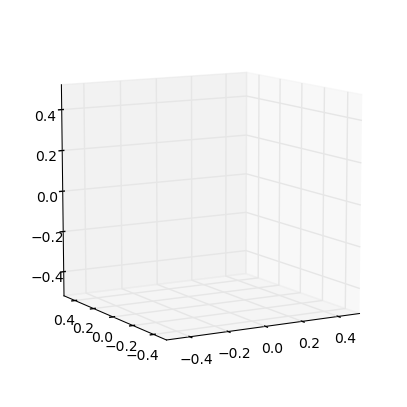

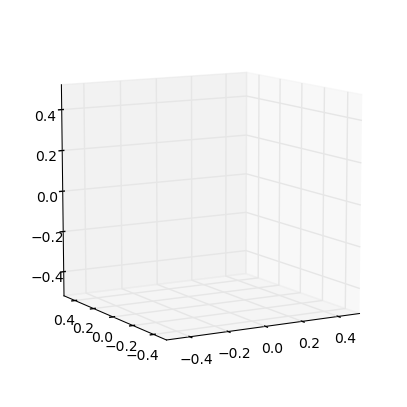

1901 (nan, nan) 26.2535030842
1902 (nan, nan) 25.993680954
1903 (nan, nan) 26.1609890461
1904 (nan, nan) 26.0853469372
1905 (nan, nan) 26.1871759892
1906 (nan, nan) 26.1006729603
1907 (nan, nan) 26.0145089626
1908 (nan, nan) 25.899009943
1909 (nan, nan) 26.0626349449
1910 (nan, nan) 26.3752670288
1911 (nan, nan) 26.0910909176
1912 (nan, nan) 26.0396401882
1913 (nan, nan) 26.0435459614
1914 (nan, nan) 26.425896883
1915 (nan, nan) 26.1380581856
1916 (nan, nan) 25.7747080326
1917 (nan, nan) 26.3276050091
1918 (nan, nan) 25.9942879677
1919 (nan, nan) 26.2688798904
1920 (nan, nan) 25.9165241718
1921 (nan, nan) 26.0078771114
1922 (nan, nan) 26.0053269863
1923 (nan, nan) 26.3667240143
1924 (nan, nan) 26.0687880516
1925 (nan, nan) 25.7080559731
1926 (nan, nan) 26.3377399445
1927 (nan, nan) 25.868144989
1928 (nan, nan) 25.8551690578
1929 (nan, nan) 26.3512918949
1930 (nan, nan) 25.8289928436
1931 (nan, nan) 26.1510000229
1932 (nan, nan) 25.8761069775
1933 (nan, nan) 25.9629950523
1934 (nan, nan

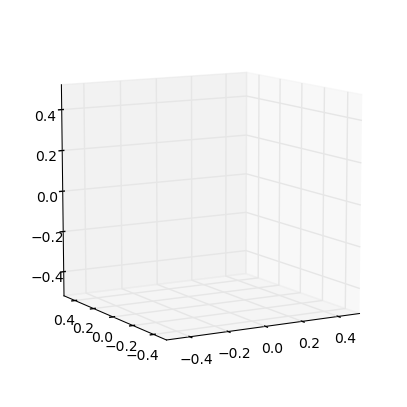

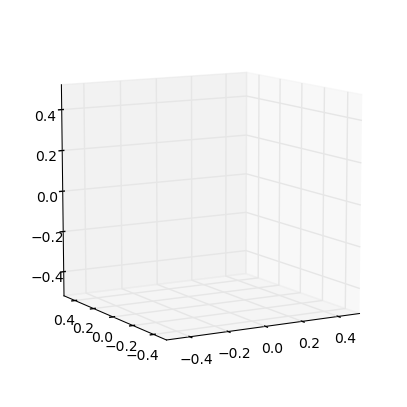

1951 (nan, nan) 25.8263959885
1952 (nan, nan) 26.0743918419
1953 (nan, nan) 25.9499368668
1954 (nan, nan) 25.9871640205
1955 (nan, nan) 26.3380079269
1956 (nan, nan) 26.1105828285
1957 (nan, nan) 25.9188530445
1958 (nan, nan) 25.861164093
1959 (nan, nan) 26.1704540253
1960 (nan, nan) 25.865229845
1961 (nan, nan) 25.9241371155
1962 (nan, nan) 26.0178310871
1963 (nan, nan) 26.1465468407
1964 (nan, nan) 25.7865738869
1965 (nan, nan) 26.0160660744
1966 (nan, nan) 26.2309989929
1967 (nan, nan) 25.89844203
1968 (nan, nan) 25.8009560108
1969 (nan, nan) 25.9240369797
1970 (nan, nan) 26.2809009552
1971 (nan, nan) 25.8817548752
1972 (nan, nan) 25.9835498333
1973 (nan, nan) 26.1034069061
1974 (nan, nan) 26.0445420742
1975 (nan, nan) 25.8702411652
1976 (nan, nan) 25.6870048046
1977 (nan, nan) 26.3596768379
1978 (nan, nan) 26.041809082
1979 (nan, nan) 25.9267940521
1980 (nan, nan) 26.1849811077
1981 (nan, nan) 26.0660018921
1982 (nan, nan) 26.1253499985
1983 (nan, nan) 25.7099051476
1984 (nan, nan)

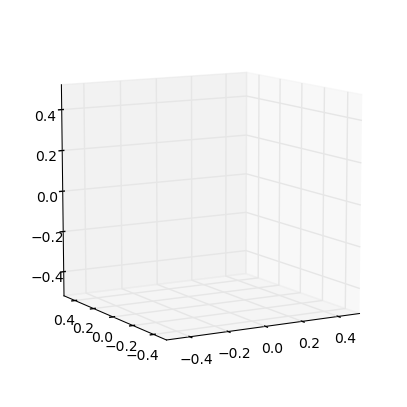

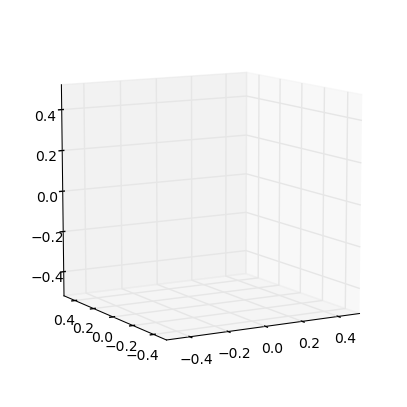

In [11]:
save_syn_data_dir = create_dir(osp.join(synthetic_data_out_dir, experiment_name))

if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params, adaptive=adaptive_training)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
        if save_model and epoch % 10 == 0:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            
        if epoch in save_synthetic_samples:
            syn_data = gan.generate(n_syn_samples, noise_params)
            accum_syn_data.append(syn_data)
            np.savez(osp.join(save_syn_data_dir, 'epoch_' + str(epoch)), syn_data)            
            for k in range(2):
                Point_Cloud(syn_data[k]).plot()
        train_stats.append((epoch,) + loss)

In [ ]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')